<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/P0_BigMonksDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frailejon Detection (a.k.a "Big Monks Detection")


En este cuadernos continuaremos con nuestra aproximación a las redes neuronales de la mano con la clasificación de imagenes.

Usted debe construir una red neuronal para detectar automáticamente plantas nativas (frailejones) sobre imagenes aerea páramo de Chingaza y Cruz Verde.

**Business Problem Framming**: Este caso de estudio hace parte de un proyecto de Ingeniería que busca preservar y monitorizar el ecosistema del páramo, de gran importancia por su potencial hídrico, mediante la propuesta de una metodología para la reconstrucción del ecosistema en zonas de baja densidad de poblaciones de la especia _Espeletia_.

## Data
Input:

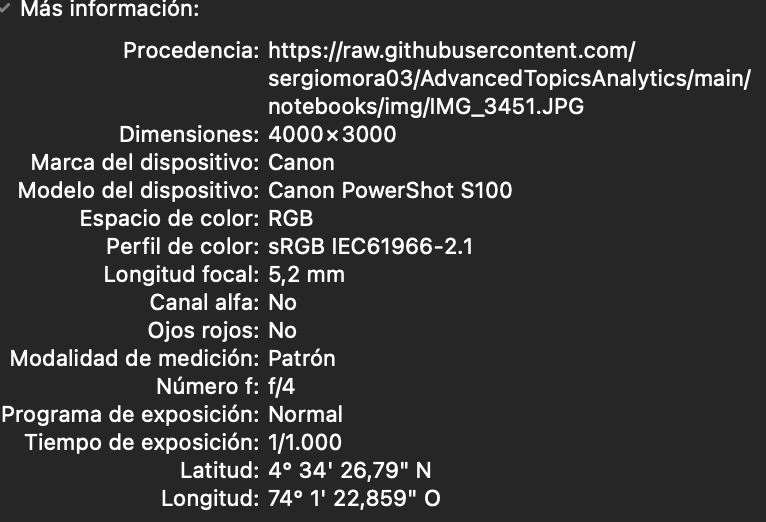

Output:
1. probability that it is a Big Monk.
2. Calculate Big Monks density

## Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".


## Requirements

- The project must be carried out in groups of 4 people.
- Use clear and rigorous procedures.
- The delivery of the project is on September 6th, 2024, 11:59 pm, through email with Github link.
- No projects will be received after the delivery time or by any other means than the one established.

## Suggestions

* Use an hyperparameter optimization framework, you can also make grid optimziation or bayesian optimization. Bonus with use:  [Optuna - A hyperparameter optimization framework](https://optuna.org/)
* Remember cualitative analysis with validation image: `IMG_3451.JPG`
* Estimate density for each Big Monks population detected. Bonus with: [Gaussian Mixture Models](https://nbviewer.jupyter.org/github/sergiomora03/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb)

## Acknowledgements
We thank Professor Camilo Franco, Ph.D.

In [64]:
!pip install -q optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.layers import ELU, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, Ftrl, Lion
from keras import regularizers
import optuna
from optuna.samplers import TPESampler

from ImportImagenesURL import import_imagenes

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
CT_xn, CT_y, CT_x22 = import_imagenes()
CT_xn.shape, CT_y.shape, CT_x22.shape

((14700, 250), (1, 250), (250, 70, 70, 3))

In [4]:
CT_y_list = pd.Series(CT_y[0])
CT_y_list.value_counts()

,count
0,145
1,105


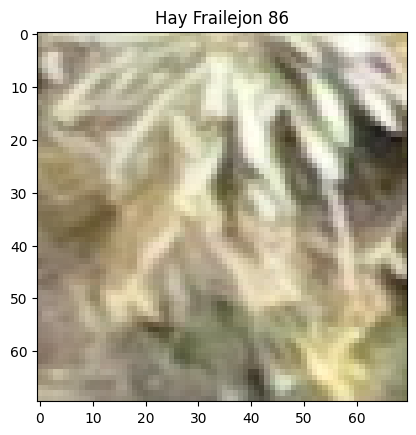

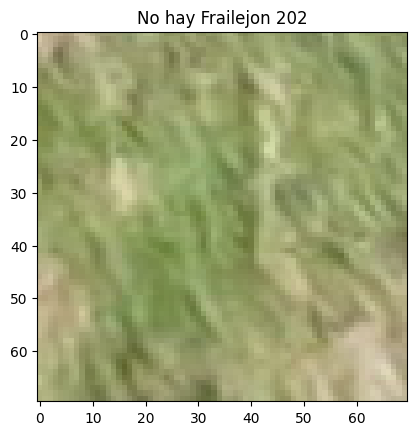

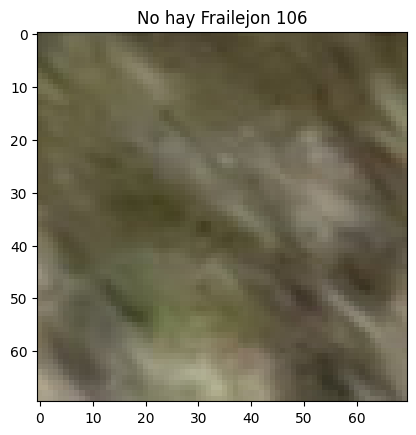

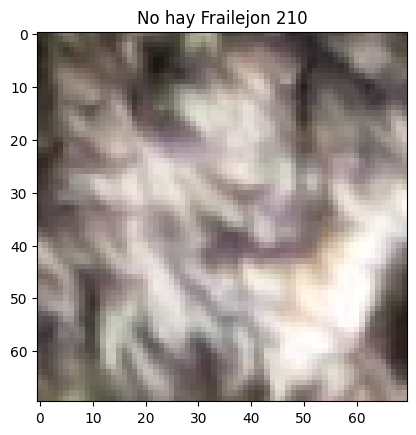

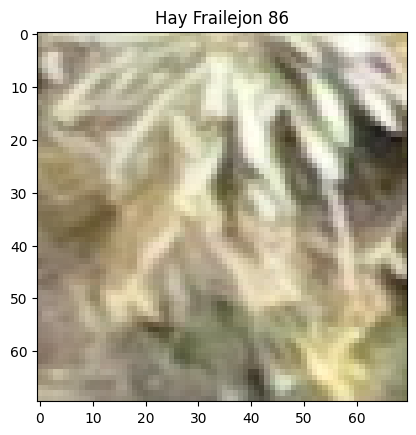

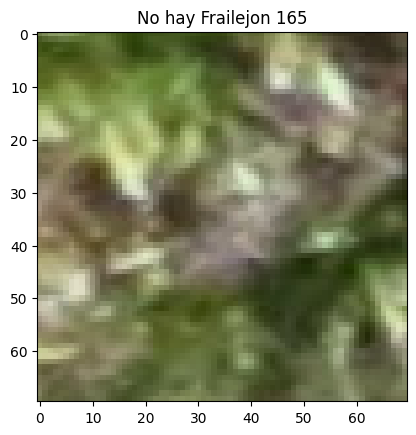

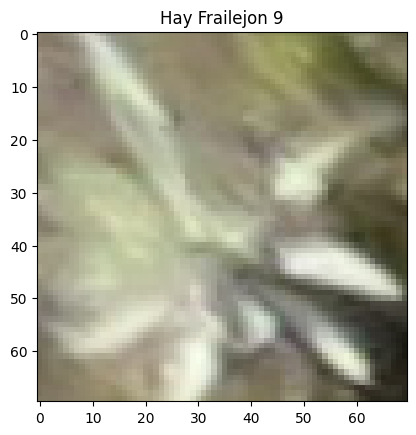

In [5]:
def muestra_image(i):
    '''
        Esta funcion grafica i imagenes aleatoriamente
    '''
    for _ in range(i):
        # Seleccionar una imagen aleatoria (0 a 249 imagenes)
        indice_aleatorio = np.random.randint(0, CT_xn.shape[1])
        imagen_elegida = CT_x22[indice_aleatorio]
        nombre_imagen = CT_y[0][indice_aleatorio]

        if nombre_imagen == 1:
            tit = f'Hay Frailejon {indice_aleatorio}'
        else:
            tit = f'No hay Frailejon {indice_aleatorio}'

        plt.imshow(imagen_elegida)
        plt.title(tit)
        plt.show()

muestra_image(7)  # Agregar

In [6]:
# train, test
train_X, test_X, train_Y, test_Y = train_test_split(CT_xn.T, CT_y_list, test_size = 0.2)
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Test data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (200, 14700) (200,)
Test data shape:  (50, 14700) (50,)


Notas:

Se tiene 250 imagenes. <br>
Solamente 105 imagenes contienen frailejones, 145 no contienen frailejones. <br>
Si hacemos train test - 200 seran para entrenamiento y 50 testeo (aun no usado).

## Conjunto de datos

Para el entrenamiento de la red neuronal, se usará el archivo `data_F`. Debe divirse en dos grupos, conjunto de entrenamiento (CE) y conjunto de validación (CV).

Adicionalmente, fuera de las métricas del modelo, se requiere que extraiga un análisis cualitativo con la imagen `IMG_3451.JPG`, donde muestre los Frilejones detectados en el area del páramo tomado por la fotografía.

Recuerde, primero, cargamos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos `X` e `Y` donde `Y`es una variable binaria.

## Caso Aplicado

### Cálculo de cantidad de Frilejones

vamos a aplicar al menos 5 modelos, se estiman los siguientes valores como resultado del entrenamiento:



*   Sencilla --> 0.88
*   Multi-capa --> 0.95
*  Convolucional --> 0.95
*  Convolucional + VGG16 --> 0.99



1. Implementa una red neuronal sencilla.

In [107]:
### Inputs (dim de datos)
input_data = CT_xn.shape[0]
### Neuronas en la capa oculta (unica capa oculta)
num_neurons = 3
### Salida
num_outputs = 1
### Taza de aprendizaje
learning_rate=0.1

In [46]:
### Definir el modelo
model = Sequential()
model.add(Dense(num_neurons, activation='relu', input_shape=(input_data,)))
model.add(Dense(num_outputs, activation='sigmoid'))
print('Structure of the neural network')
print(model.summary())

Estructura de la red


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 3)                   │          44,103 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,107 (172.29 KB)

 Trainable params: 44,107 (172.29 KB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
### Definir compilador

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['binary_accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate),
#               metrics=['auc'])

### Ajustar el modelo
model.fit(CT_xn.T, CT_y_list,
          epochs=500,
          batch_size=None,
          validation_split=0.05,
          verbose=False)

In [62]:
scores = model.evaluate(CT_xn.T, CT_y_list)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.2964 - loss: 0.7779     
compile_metrics: 58.00%


Usamos Optuna para mejorar la Red neuronal

In [105]:
def objective(trial):

    '''
    Function to optimize hyperparameter searching with OPTUNA - Neuronal Network
    '''

    # Define the search space
    units = trial.suggest_int('units', 32, 700)
    activation = trial.suggest_categorical('activation', ['relu', 'relu', 'tanh', 'sigmoid'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'Ftrl', 'Lion'])
    epochs = trial.suggest_int('epochs', 10, 100)
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
      optimizer = RMSprop(learning_rate=lr)
    elif optimizer_name == 'Ftrl':
        optimizer = Ftrl(learning_rate=lr)
    else:
        optimizer = Lion(learning_rate=lr)

    ##### Define model

    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(input_data,)))
    model.add(Dense(num_outputs, activation='sigmoid'))

    ### Definir compilador
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['binary_accuracy'])

    # model.compile(loss='binary_crossentropy',
    #               optimizer=tf.keras.optimizers.Adam(learning_rate),
    #               metrics=['auc'])

    ### Ajustar el modelo
    model.fit(CT_xn.T, CT_y_list,
              epochs=epochs,
              batch_size=None,
              validation_split=0.1,
              verbose=True)

    ### Calificacion del modelo
    scores = model.evaluate(test_X, test_Y)[1]  # Para que almacene el acc

    return scores

In [108]:
study_snn = optuna.create_study(study_name="model_simple_neural_network",
                                direction="maximize",
                                pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                                sampler=TPESampler())
study_snn.optimize(objective, n_trials=100)

[I 2024-09-02 18:20:13,322] A new study created in memory with name: model_simple_neural_network


Epoch 1/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - binary_accuracy: 0.4796 - loss: 600.0720 - val_binary_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.5095 - loss: 53.8147 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7306
Epoch 3/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - binary_accuracy: 0.4483 - loss: 3.7816 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7306
Epoch 4/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - binary_accuracy: 0.4811 - loss: 0.6940 - val_binary_accuracy: 0.9200 - val_loss: 0.6930
Epoch 5/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - binary_accuracy: 0.4747 - loss: 0.6947 - val_binary_accuracy: 0.9200 - val_loss: 0.6930
Epoch 6/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - binary_accuracy: 0.5372 - loss: 0.6945 - val_binary_accuracy: 1.0000 - val_loss: 0.6568
Epoch 7/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - binary_accuracy: 0.5006 - loss: 0.6944 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.7306
Epo

[I 2024-09-02 18:21:11,079] Trial 0 finished with value: 0.6600000262260437 and parameters: {'units': 457, 'activation': 'relu', 'optimizer': 'Lion', 'epochs': 53, 'lr': 0.03690053050003948}. Best is trial 0 with value: 0.6600000262260437.


Epoch 1/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - binary_accuracy: 0.4655 - loss: 1.0837 - val_binary_accuracy: 1.0000 - val_loss: 0.4661
Epoch 2/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - binary_accuracy: 0.4727 - loss: 0.7130 - val_binary_accuracy: 1.0000 - val_loss: 0.2672
Epoch 3/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - binary_accuracy: 0.5474 - loss: 0.7455 - val_binary_accuracy: 0.6800 - val_loss: 0.6433
Epoch 4/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - binary_accuracy: 0.6321 - loss: 0.5995 - val_binary_accuracy: 0.9600 - val_loss: 0.4911
Epoch 5/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - binary_accuracy: 0.7347 - loss: 0.5706 - val_binary_accuracy: 1.0000 - val_loss: 0.3963
Epoch 6/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - binary_accuracy: 0.8034 - loss: 0.5194 - val_binary_accuracy: 1.0000 - val_loss: 0.2630
Epoch 7/59
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - binary_accuracy: 0.7361 - loss: 0.5160 - val_binary_accuracy: 1.0000 - val_loss: 0.2559
Epoch 8/59
8/8 ━━━━━━━━━

[I 2024-09-02 18:22:12,629] Trial 1 finished with value: 0.7599999904632568 and parameters: {'units': 397, 'activation': 'relu', 'optimizer': 'adam', 'epochs': 59, 'lr': 3.858306677594275e-05}. Best is trial 1 with value: 0.7599999904632568.


In [101]:
snn = study_snn.best_params
snn

{'units': 98,
 'activation': 'tanh',
 'optimizer': 'adam',
 'epochs': 61,
 'lr': 2.2278666355973474e-05}

In [109]:
### Definir el modelo
model = Sequential()
model.add(Dense(snn['units'], activation=snn['activation'], input_shape=(input_data,)))
model.add(Dense(num_outputs, activation='sigmoid'))
print('Structure of the neural network')
print(model.summary())
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=snn['lr']),
              metrics=['binary_accuracy'])

Structure of the neural network


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                     │ (None, 98)                  │       1,440,698 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,440,797 (5.50 MB)

 Trainable params: 1,440,797 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [110]:
  ### Ajustar el modelo
  model.fit(CT_xn.T, CT_y_list,
            epochs=snn['epochs'],
            batch_size=None,
            validation_split=0.05,
            verbose=True)

  ### Calificacion del modelo
  scores = model.evaluate(test_X, test_Y)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - binary_accuracy: 0.5950 - loss: 0.6832 - val_binary_accuracy: 0.3846 - val_loss: 0.7331
Epoch 2/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.6530 - loss: 0.6345 - val_binary_accuracy: 1.0000 - val_loss: 0.2331
Epoch 3/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.6989 - loss: 0.5954 - val_binary_accuracy: 1.0000 - val_loss: 0.2006
Epoch 4/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.6823 - loss: 0.5849 - val_binary_accuracy: 1.0000 - val_loss: 0.3497
Epoch 5/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7785 - loss: 0.5407 - val_binary_accuracy: 1.0000 - val_loss: 0.1464
Epoch 6/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - binary_accuracy: 0.7364 - loss: 0.5218 - val_binary_accuracy: 1.0000 - val_loss: 0.3135
Epoch 7/61
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.7482 - loss: 0.5002 - val_binary_accuracy: 1.0000 - val_loss: 0.1600
Epoch 8/61
8/8 ━━━━━━━━━━━━



2. Implementa una red neuronal multi-capa


In [ ]:
###
###  Falta hacerla a manita por que no esta aprendiendo, agregarle inicializador que sea los del profesor u otro
###  optimizador, probar activaciones
###

# Definir el modelo
model = Sequential()
model.add(Dense(700, activation='relu', input_shape=(14700,)))
model.add(Dense(500, kernel_initializer='uniform', activation='relu'))
model.add(Dense(300, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['auc'])

# Entrenar el modelo
model.fit(CT_xn.T, CT_y_list, epochs=100, batch_size=32, validation_split=0.2)

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.5013 - loss: 2.8715 - val_accuracy: 0.0000e+00 - val_loss: 1.0651
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5671 - loss: 0.7980 - val_accuracy: 0.0000e+00 - val_loss: 1.3293
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.5402 - loss: 0.6970 - val_accuracy: 0.0000e+00 - val_loss: 0.4542
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.5244 - loss: 0.6865 - val_accuracy: 0.0000e+00 - val_loss: 0.6106
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.5438 - loss: 0.8092 - val_accuracy: 0.0000e+00 - val_loss: 0.5305
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.5484 - loss: 0.6988 - val_accuracy: 0.0000e+00 - val_loss: 0.5484
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5682 - loss: 0.6913 - val_accuracy: 0.0000e+00 - val_loss: 0.3736
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5564 - loss: 0.6538 - val_accu

In [ ]:
scores = model.evaluate(test_X, test_Y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4021 - loss: 3.1063
compile_metrics: 40.00%


3. Implementa una red neuronal convolucional





4. Implementa una red neuronal convolucional con tranferencia VGG-16



5. Implementa una red neuronal convolucional con tranferencia VGG-16 y ajuste de hiperparámetros (bono por uso de Optuna).






6. Responda: **¿Qué puede observar sobre el desempeño de los diferentes modelos? Argumente cuál es el mejor modelo para poner en producción.**

7. Investigue otra red pre-entrenada dsitinta a la VGG-16 e implemente el aprendizaje por transferencia para la deteccion de frailejones. Argumente por qué su justifica el aprendizaje por transferencia con base en el modelo pre-entrenado de su elección (cómo se relacionan la tarea base y la segunda tarea objetivo).

### Cálculo de densidad poblacional por grupos de Frilejones

Iniciaremos con el cálculo total de frilejones en la imagen y con ello (de acuerdo con la ayuda) tendrémos la densidad de frilejones. Para ello únicamente correremos el loop nuevamente y cambiaremos un poco sus parametros para contar el número exacto de frilejones en la imagen.

NOTA: aprovecharemos también para sacar la ubicaciónd de cada frilejon simulando "latitud y longitud". Como se muestra en la siguiente imagen:


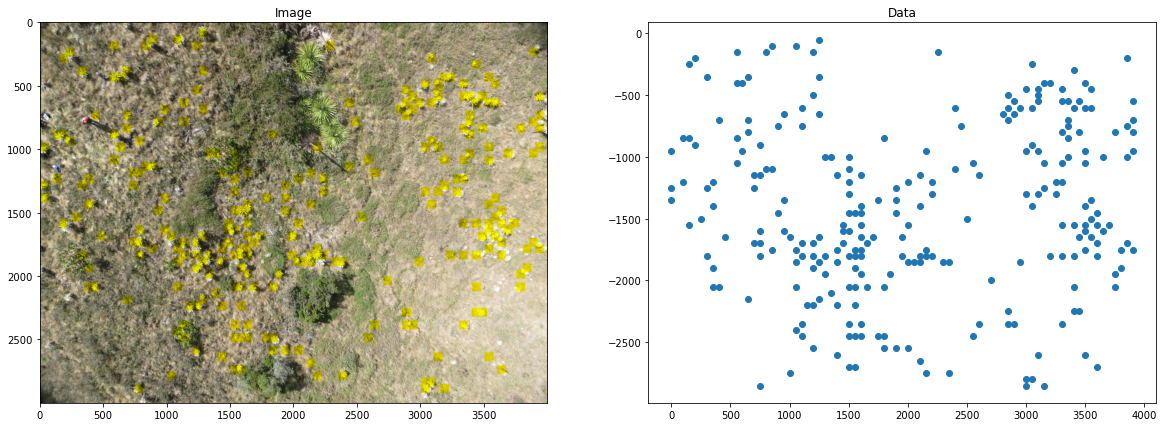


Una vez calculada la cantidad total de frilejones en la imagen, debe hacer el cálculo de la densidad poblacional. Se recomienda el uso de un GMM o puede aplicar algún análisis, heurística que identifique los grupos de frilejosnes en la imagen y la densidad en cada grupo.

Se intentó entrenar un modelo GMM con un dataset de 14700 columnas, pero los requerimientos computacionales eran excesivos. Se aplicó PCA para reducir la dimensionalidad y permitir el entrenamiento. Posteriormente, se planea repetir el entrenamiento sin PCA en un equipo más potente. La generación de gráficos dependerá de los resultados de estos experimentos

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Aplicar PCA
pca = PCA()
pca.fit(CT_xn.T)

PCA()

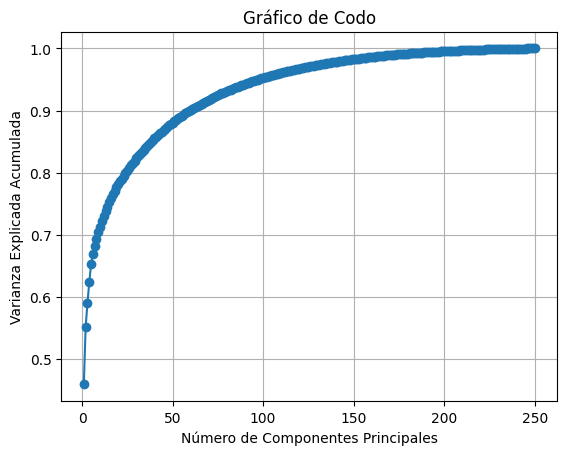

In [ ]:
# Obtener la varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Graficar el gráfico de codo
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfico de Codo')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(CT_xn.T)

In [ ]:
#
# Numero de componentes
#
n_components = np.arange(1, 10)

gaussianModels = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(X_reduced)
    for n in n_components
]

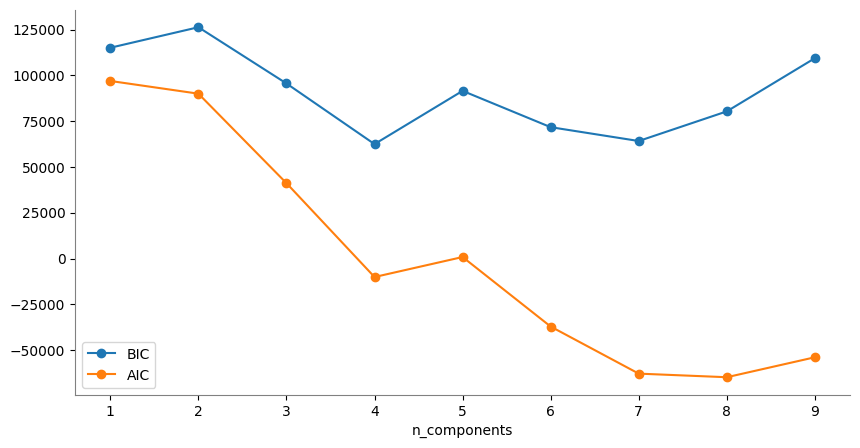

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(n_components, [model.bic(X_reduced) for model in gaussianModels], "o-", label="BIC")
plt.plot(n_components, [model.aic(X_reduced) for model in gaussianModels], "o-", label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

Interpretación del Gráfico y Selección del Número Óptimo de Componentes según AIC en un Modelo GMM
Entendiendo el Gráfico
El gráfico que presentas es una herramienta común en el modelado de mezclas gaussianas (GMM) para seleccionar el número óptimo de componentes. En este caso, las dos métricas principales que se están evaluando son el Criterio de Información Bayesiano (BIC) y el Criterio de Información de Akaike (AIC).

Eje X: Representa el número de componentes en el modelo GMM.
Eje Y: Representa el valor de las métricas BIC y AIC para cada número de componentes.
¿Qué nos dice el AIC?
El AIC es una estimación de la calidad relativa de los modelos estadísticos para un conjunto de datos dado. Un valor más bajo de AIC indica un mejor ajuste del modelo a los datos.

En el gráfico, el valor mínimo de AIC se alcanza en el componente número 4. Esto sugiere que, según el criterio de AIC, un modelo GMM con 4 componentes es el que mejor se ajusta a los datos, penalizando adecuadamente la complejidad del modelo.

¿Por qué el AIC sugiere 4 componentes?

- Ajuste vs. Complejidad: El AIC busca un equilibrio entre la capacidad del modelo para ajustar los datos (menor error) y su complejidad (menor número de parámetros).
- Penalización: A medida que aumenta el número de componentes, el AIC aplica una penalización más fuerte para evitar el sobreajuste.
- Mínimo Global: El punto más bajo en la curva de AIC indica el número de componentes donde esta penalización se equilibra con la mejora en el ajuste.

In [ ]:
#
# Numero de componentes
#
n_components = np.arange(1, 3)

gaussianModels = [
    GaussianMixture(n, covariance_type="full", random_state=0).fit(CT_xn.T)
    for n in n_components
]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(n_components, [model.bic(CT_xn.T) for model in gaussianModels], "o-", label="BIC")
plt.plot(n_components, [model.aic(CT_xn.T) for model in gaussianModels], "o-", label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()